In [1]:
import numpy as np
import six
import os
import glob
import pickle
import skimage.io as skio
import skimage.transform as skit
import skimage.morphology as skim
from sklearn.base import clone

import pulse2percept as p2p
import p2pspatial

%matplotlib inline
import matplotlib.pyplot as plt

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-03-03 19:50:14,006 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
img_argus1 = skio.imread('/home/mbeyeler/Dropbox/UW/argus_i.jpg')
img_argus2 = skio.imread('/home/mbeyeler/Dropbox/UW/argus_ii.jpg')

In [3]:
px_argus2 = np.array([
    [ 296.94026284,  140.58506571], [ 328.48148148,  138.4823178 ],
    [ 365.27956989,  140.58506571], [ 397.87216249,  139.53369176],
    [ 429.41338112,  138.4823178 ], [ 463.05734767,  140.58506571],
    [ 495.64994026,  139.53369176], [ 528.24253286,  139.53369176],
    [ 560.83512545,  139.53369176], [ 593.42771804,  138.4823178 ],
    [ 296.94026284,  173.1776583 ], [ 329.53285544,  174.22903226],
    [ 363.17682198,  173.1776583 ], [ 396.82078853,  173.1776583 ],
    [ 430.46475508,  173.1776583 ], [ 463.05734767,  174.22903226],
    [ 494.59856631,  173.1776583 ], [ 529.29390681,  174.22903226],
    [ 559.78375149,  175.28040621], [ 593.42771804,  173.1776583 ],
    [ 296.94026284,  206.82162485], [ 329.53285544,  206.82162485],
    [ 363.17682198,  205.7702509 ], [ 395.76941458,  205.7702509 ],
    [ 429.41338112,  205.7702509 ], [ 463.05734767,  208.92437276],
    [ 496.70131422,  207.87299881], [ 529.29390681,  209.97574671],
    [ 559.78375149,  208.92437276], [ 592.37634409,  206.82162485],
    [ 296.94026284,  240.4655914 ], [ 330.58422939,  240.4655914 ],
    [ 363.17682198,  240.4655914 ], [ 396.82078853,  240.4655914 ],
    [ 430.46475508,  240.4655914 ], [ 460.95459976,  240.4655914 ],
    [ 494.59856631,  242.56833931], [ 528.24253286,  239.41421744],
    [ 559.78375149,  240.4655914 ], [ 593.42771804,  241.51696535],
    [ 297.9916368 ,  274.10955795], [ 328.48148148,  273.05818399],
    [ 361.07407407,  274.10955795], [ 395.76941458,  273.05818399],
    [ 428.36200717,  274.10955795], [ 463.05734767,  273.05818399],
    [ 494.59856631,  275.1609319 ], [ 526.13978495,  274.10955795],
    [ 560.83512545,  274.10955795], [ 591.32497013,  274.10955795],
    [ 295.88888889,  306.70215054], [ 329.53285544,  305.65077658],
    [ 363.17682198,  305.65077658], [ 393.66666667,  307.75352449],
    [ 427.31063321,  307.75352449], [ 459.90322581,  305.65077658],
    [ 492.4958184 ,  308.80489845], [ 527.1911589 ,  307.75352449],
    [ 559.78375149,  307.75352449], [ 590.27359618,  306.70215054]
])

In [4]:
subject = '12-005'
model = 'F2'

picklefolder = os.path.join('..', '..', 'results', 'newLOO', 'fit')
datafolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape', subject)

In [5]:
findstr = "%s-fit-swarm_%s_*.pickle" % (model, subject)
files = glob.glob(os.path.join(picklefolder, findstr))
assert len(files) == 1
_, _, best_params, specifics = pickle.load(open(files[0], 'rb'))

In [6]:
amplitude = specifics['amplitude']

In [7]:
best_params

{'axlambda': 650.33752489720553,
 'implant_rot': -0.23416786741221765,
 'implant_x': -675.59525756584355,
 'implant_y': 138.23063957231915,
 'loc_od_x': 13.991746801178984,
 'loc_od_y': 1.3127601087364495,
 'rho': 349.95078180218246}

In [8]:
if 'implant_x' not in best_params:
    best_params['implant_x'] = 0
    best_params['implant_y'] = 0
    best_params['implant_rot'] = 0

In [9]:
argus = p2p.implants.ArgusII(x_center=best_params['implant_x'],
                             y_center=best_params['implant_y'],
                             rot=best_params['implant_rot'])

In [10]:
x_range = (-30, 30)
y_range = (-20, 20)
out_shape = (768, 1024)

In [11]:
pts_in = []
pts_dva = []
pts_out = []
for xy, e in zip(px_argus2, argus):
    pts_in.append(xy)
    
    dva = p2p.retina.ret2dva([e.x_center, e.y_center])
    pts_dva.append(dva)
    
    xout = (dva[0] - x_range[0]) / (x_range[1] - x_range[0]) * (out_shape[1] - 1)
    yout = (dva[1] - y_range[0]) / (y_range[1] - y_range[0]) * (out_shape[0] - 1)
    pts_out.append([xout, yout])

In [12]:
argus2dva = skit.estimate_transform('similarity', np.array(pts_in), np.array(pts_dva))
dva2out = skit.estimate_transform('similarity', np.array(pts_dva), np.array(pts_out))
argus2out = skit.estimate_transform('similarity', np.array(pts_in), np.array(pts_out))

In [13]:
def get_avg_image(X, electrode, amp, align_center, scale=1):
    idx = (X['electrode'] == electrode) & (X['amplitude'] == amp)
    avg_img = y[idx]['image'].values
    
    if len(avg_img) == 0:
        return None

    avg_img = avg_img[0] / avg_img[0].max()
    
    avg_img = p2pspatial.imgproc.scale_phosphene(avg_img, scale)

    transl = [align_center[0] - avg_img.shape[1] // 2,
              align_center[1] - avg_img.shape[0] // 2]
    trafo = skit.EuclideanTransform(translation=transl)
    avg_img = skit.warp(avg_img, trafo.inverse)
    return avg_img

In [14]:
X, y = p2pspatial.load_data(datafolder, subject=subject, amplitude=amplitude)
X, y = p2pspatial.transform_mean_images(X, y, threshold=False)

In [15]:
electrodes = np.unique(X.groupby(['electrode', 'amplitude']).electrode.all())
amps = np.unique(X['amplitude'])
assert len(amps) == 1
assert np.isclose(amps, amplitude)
print(electrodes)
print(amplitude)

['A01' 'A04' 'A06' 'A08' 'B01' 'B03' 'B09' 'C07' 'C10' 'D01' 'D04' 'D07'
 'D08' 'D10' 'E01' 'E03' 'E07' 'E10' 'F02' 'F04' 'F06' 'F09']
2.0


In [16]:
reg = clone(specifics['regressor'])
reg

ModelF(ax_segments_range=(3, 50), axlambda=650.33752489720553,
    axons_range=(-180, 180), engine='joblib', greater_is_better=False,
    img_thresh=0.60653065971263342, implant_rot=-0.23416786741221765,
    implant_type=<class 'pulse2percept.implants.ArgusII'>,
    implant_x=-675.59525756584355, implant_y=138.23063957231915,
    loc_od_x=13.991746801178984, loc_od_y=1.3127601087364495,
    n_ax_segments=71, n_axons=301, n_jobs=-1, rho=349.95078180218246,
    scheduler='threading', xrange=(-30, 30), xystep=0.5, yrange=(-20, 20))

In [17]:
if hasattr(reg, 'n_ax_segments'):
    reg.set_params(xystep=0.25, n_ax_segments=301, axlambda=300)#, rho=80, axlambda=800)
reg._curr_map = {}
!rm axons.pickle
reg.fit(X)

rm: cannot remove 'axons.pickle': No such file or directory


ModelF(ax_segments_range=(3, 50), axlambda=300, axons_range=(-180, 180),
    engine='joblib', greater_is_better=False,
    img_thresh=0.60653065971263342, implant_rot=-0.23416786741221765,
    implant_type=<class 'pulse2percept.implants.ArgusII'>,
    implant_x=-675.59525756584355, implant_y=138.23063957231915,
    loc_od_x=13.991746801178984, loc_od_y=1.3127601087364495,
    n_ax_segments=301, n_axons=301, n_jobs=-1, rho=349.95078180218246,
    scheduler='threading', xrange=(-30, 30), xystep=0.25, yrange=(-20, 20))

In [18]:
def get_pred_image(Xrow, model, align_center, scale=1):
    pred_img = model._predicts_image(Xrow)
    if pred_img is None:
        return None
    
    pred_img = p2pspatial.imgproc.get_thresholded_image(pred_img, thresh=model.img_thresh,
                                                        out_shape=Xrow[1]['img_shape'])
    pred_img = p2pspatial.imgproc.center_phosphene(pred_img)
#     img_avg_th = skim.binary_closing(pred_img, selem=skim.disk(51))

    pred_img = p2pspatial.imgproc.scale_phosphene(pred_img, scale)

    transl = [align_center[0] - pred_img.shape[1] // 2,
              align_center[1] - pred_img.shape[0] // 2]
    trafo = skit.EuclideanTransform(translation=transl)
    pred_img = skit.warp(pred_img, trafo.inverse)
    return pred_img

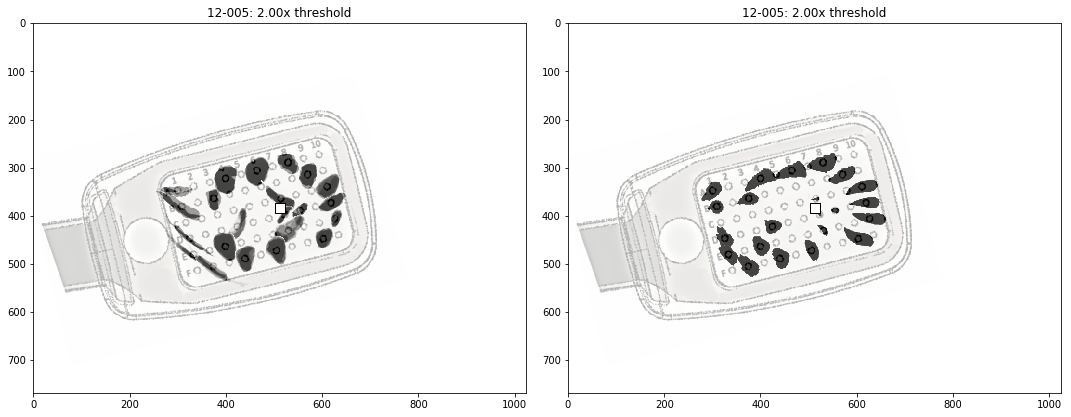

In [19]:
fovea = dva2out([0, 0])[0]
scale = 0.6

fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
fig.tight_layout()

ax = axes[0]
ax.set_facecolor('white')
for el in electrodes:
    ename = '%s%d' % (el[0], int(el[1:]))
    e_pos = p2p.retina.ret2dva((argus[ename].x_center, argus[ename].y_center))
    align_center = dva2out(e_pos)[0]
    avg = get_avg_image(X, el, amplitude, align_center, scale=scale)
    if avg is None:
        continue
    ax.imshow(1 - np.ma.masked_where(avg < 0.5, avg), cmap='gray')
    ax.set_title('%s: %.2fx threshold' % (subject, amplitude))
ax.imshow(skit.warp(img_argus2, argus2out.inverse, cval=1.0, output_shape=out_shape), alpha=0.3)
ax.scatter(fovea[0], fovea[1], s=100, marker='s', c='w', edgecolors='k')

ax = axes[1]
ax.set_facecolor('white')
for Xrow in X.iterrows():
    el = Xrow[1]['electrode']
    ename = '%s%d' % (el[0], int(el[1:]))
    e_pos = p2p.retina.ret2dva((argus[ename].x_center, argus[ename].y_center))
    align_center = dva2out(e_pos)[0]
    pred_img = get_pred_image(Xrow, reg, align_center, scale=scale)
    if pred_img is None:
        continue
    ax.imshow(1 - np.ma.masked_where(pred_img < 0.5, pred_img), cmap='gray')
#     ax.imshow(1 - pred_img, cmap='gray')
    ax.set_title('%s: %.2fx threshold' % (subject, amplitude))
ax.imshow(skit.warp(img_argus2, argus2out.inverse, cval=1.0, output_shape=out_shape), alpha=0.3)
ax.scatter(fovea[0], fovea[1], s=100, marker='s', c='w', edgecolors='k')

fig.savefig('shape-%s-%s.png' % (subject, model))

In [32]:
X.loc[0, 'electrode']

'A01'

In [33]:
y_pred = get_pred_image((0, X.loc[0, :]), reg, [500, 300])

In [38]:
y_true = get_avg_image(X, 'A01', 2.0, [500, 300])

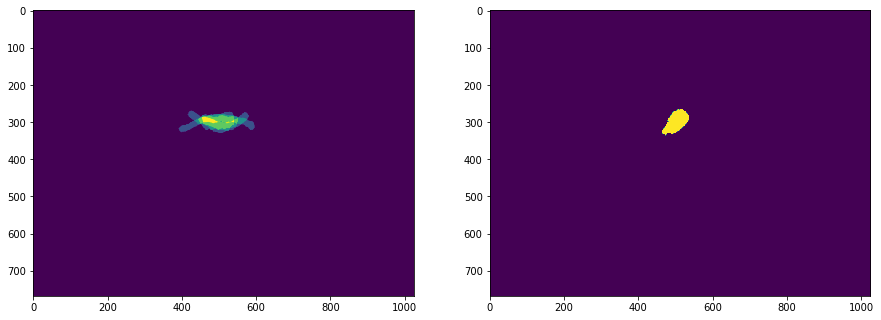

In [39]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.imshow(y_true)
plt.subplot(122)
plt.imshow(y_pred)

In [41]:
y_true = p2pspatial.imgproc.scale_phosphene(y_true, 1.5)
y_pred = p2pspatial.imgproc.scale_phosphene(y_pred, 1.5)

In [43]:
p2pspatial.imgproc.dice_coeff(p2pspatial.imgproc.get_thresholded_image(y_true, thresh=0.5), y_pred)

0.60017797248271609